#  Imports

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
from tensorflow.keras import Model , layers, Sequential
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
import random
from sklearn.model_selection import train_test_split

In [3]:
tf.config.list_physical_devices('GPU')

tf.keras.backend.clear_session()
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Dataset


In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/train",
    labels=None,
    batch_size=None,  # No usar batch aquí para tener control total luego
    image_size=(128, 128),
    color_mode="rgb",
    shuffle=True,
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/val",
    labels=None,
    batch_size=None,
    image_size=(128, 128),
    color_mode="rgb",
    shuffle=True,
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/test",
    labels=None,
    batch_size=None,
    image_size=(128, 128),
    color_mode="rgb",
    shuffle=True,
)

# Normalización de imágenes
def normalize(image):
    return tf.cast(image, tf.float32) / 255.0

train_dataset = train_dataset.map(normalize)
val_dataset = val_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

# Función que convierte a escala de grises como input y conserva el RGB como output
def rgb_to_grayscale_input(image):
    gray = tf.image.rgb_to_grayscale(image)
    gray = tf.image.grayscale_to_rgb(gray)  # Mantiene shape [H, W, 3]
    return gray, image  # (input, target)

# Aplicar la conversión a cada dataset
colorization_train_dataset = train_dataset.map(rgb_to_grayscale_input).shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)
colorization_val_dataset = val_dataset.map(rgb_to_grayscale_input).batch(64).prefetch(tf.data.AUTOTUNE)
colorization_test_dataset = test_dataset.map(rgb_to_grayscale_input).batch(64).prefetch(tf.data.AUTOTUNE)

Found 21000 files belonging to 1 classes.
Found 3000 files belonging to 1 classes.
Found 6000 files belonging to 1 classes.


In [6]:

def create_autoencoder(input_shape=(224, 224, 1)):
    model = tf.keras.Sequential([
        # Encoder
        layers.Input(shape=input_shape),
    
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Dropout(0.2),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Dropout(0.2),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Dropout(0.3),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Dropout(0.3),

        # Bottleneck
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),


        # Decoder
        layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.UpSampling2D((2, 2)),

        layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.UpSampling2D((2, 2)),

        layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.UpSampling2D((2, 2)),

        layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.UpSampling2D((2, 2)),

        # Output
        layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
        ])
    return model


model = create_autoencoder((128, 128, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_8 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_9 (Batc  (None, 64, 64, 64)      

In [7]:
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)
def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

In [8]:
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)
def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="mse",metrics=["mae", psnr, ssim])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_autoecoder_colorization.h5", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1),
]
history = model.fit(
    colorization_train_dataset,  # tf.data.Dataset o generator
    verbose=1,  # Mostrar progreso
    validation_data=colorization_test_dataset,  # validación con rotaciones también
    epochs=50,
    batch_size=8,  # Puedes probar 64 o 128 según tu GPU
    callbacks=callbacks,
)
save_path = "best_autoecoder_colorization.h5"


Epoch 1/50
329/329 [==============================] - 45s 117ms/step - loss: 0.0321 - mae: 0.1312 - psnr: 15.5481 - ssim: 0.3578 - val_loss: 0.0482 - val_mae: 0.1777 - val_psnr: 13.3736 - val_ssim: 0.3277 - lr: 0.0010
Epoch 2/50
329/329 [==============================] - 38s 112ms/step - loss: 0.0262 - mae: 0.1161 - psnr: 16.3871 - ssim: 0.4033 - val_loss: 0.0271 - val_mae: 0.1261 - val_psnr: 16.0641 - val_ssim: 0.4085 - lr: 0.0010
Epoch 3/50
329/329 [==============================] - 37s 110ms/step - loss: 0.0239 - mae: 0.1099 - psnr: 16.8081 - ssim: 0.4282 - val_loss: 0.0279 - val_mae: 0.1341 - val_psnr: 15.8461 - val_ssim: 0.4235 - lr: 0.0010
Epoch 4/50
329/329 [==============================] - 37s 110ms/step - loss: 0.0228 - mae: 0.1068 - psnr: 17.0414 - ssim: 0.4465 - val_loss: 0.0348 - val_mae: 0.1506 - val_psnr: 14.8516 - val_ssim: 0.4204 - lr: 0.0010
Epoch 5/50
329/329 [==============================] - 37s 111ms/step - loss: 0.0230 - mae: 0.1074 - psnr: 17.0041 - ssim: 0.4481

<Figure size 1200x600 with 0 Axes>

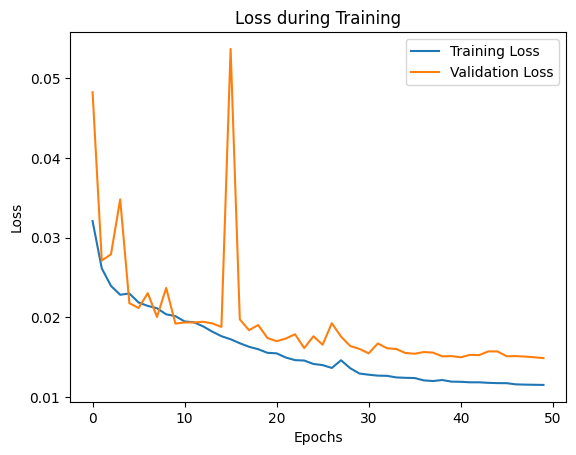

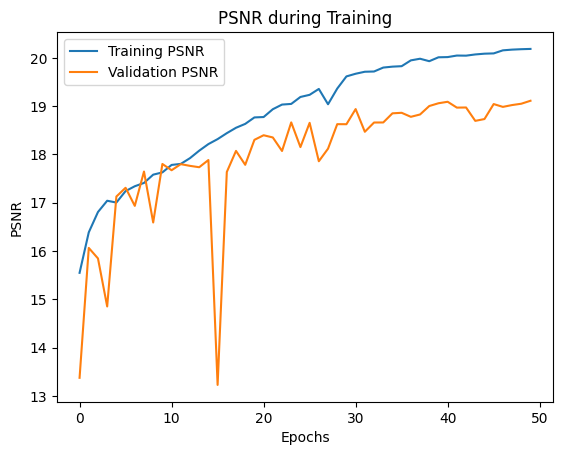

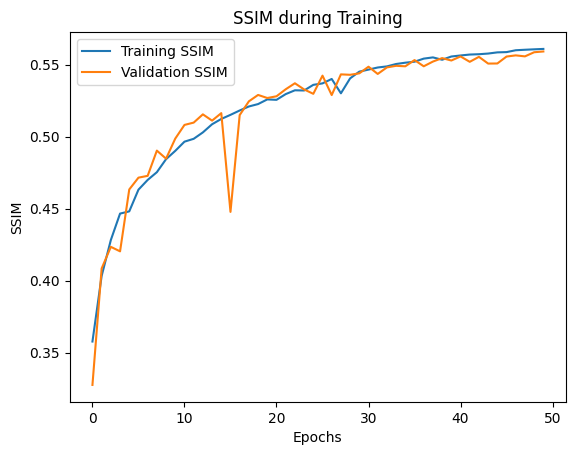

In [9]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    
    # Pérdida
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss during Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # PSNR
    plt.figure()
    plt.plot(history.history['psnr'], label='Training PSNR')
    plt.plot(history.history['val_psnr'], label='Validation PSNR')
    plt.title('PSNR during Training')
    plt.xlabel('Epochs')
    plt.ylabel('PSNR')
    plt.legend()
    plt.show()

    # SSIM
    plt.figure()
    plt.plot(history.history['ssim'], label='Training SSIM')
    plt.plot(history.history['val_ssim'], label='Validation SSIM')
    plt.title('SSIM during Training')
    plt.xlabel('Epochs')
    plt.ylabel('SSIM')
    plt.legend()
    plt.show()

# Llamar a la función para graficar el progreso del entrenamiento
plot_training_history(history)

2/2 [==============================] - 1s 7ms/step


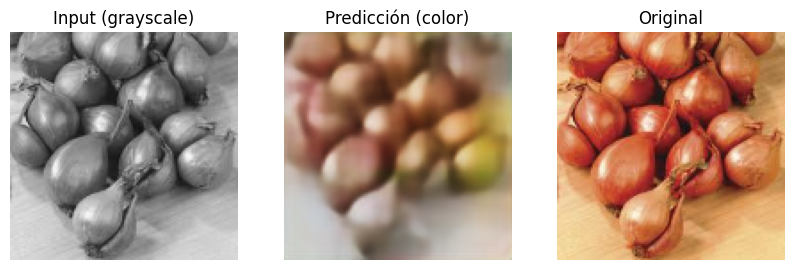

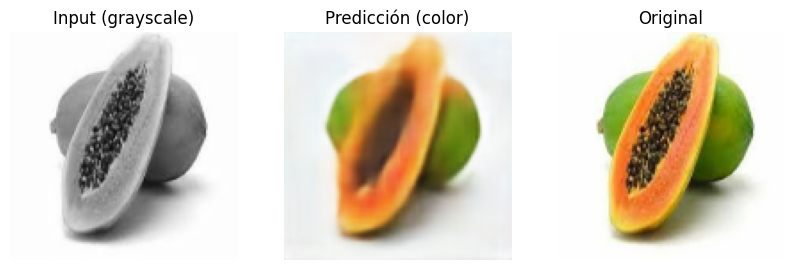

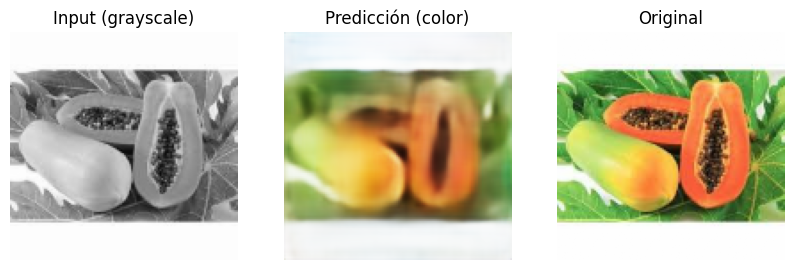

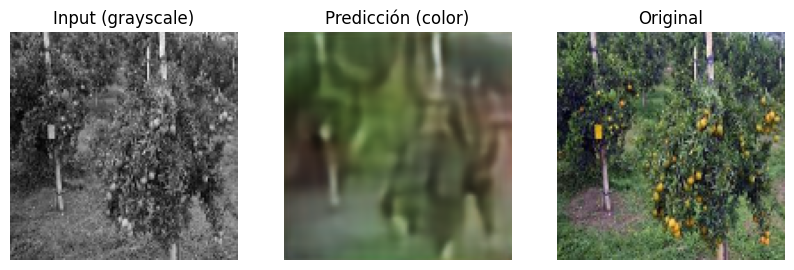

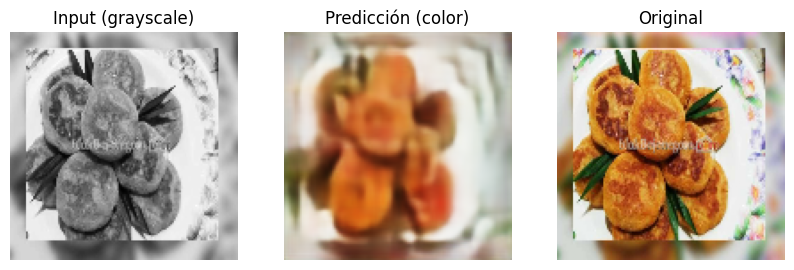

In [10]:
def show_colorization_examples(dataset, model, n=5):
    for images_gray, images_real in dataset.take(1):
        preds = model.predict(images_gray)

        for i in range(n):
            plt.figure(figsize=(10, 3))

            plt.subplot(1, 3, 1)
            plt.imshow(images_gray[i])
            plt.title("Input (grayscale)")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(preds[i])
            plt.title("Predicción (color)")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(images_real[i])
            plt.title("Original")
            plt.axis("off")

            plt.show()
show_colorization_examples(colorization_val_dataset, model, n=5)

In [65]:
classification_train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/train",
    image_size=(128, 128),
    batch_size=64,
    label_mode="int",        # o "categorical" según el loss
    color_mode="rgb",       
    shuffle=True
).map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).shuffle(1000).prefetch(tf.data.AUTOTUNE)
classification_val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/val",
    image_size=(128, 128),
    batch_size=64,
    label_mode="int",
    color_mode="rgb",
    shuffle=False
).map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).shuffle(1000).prefetch(tf.data.AUTOTUNE)

classification_test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory="e:/TFM/PlantsClassification/test",
    image_size=(128, 128),
    batch_size=64,
    label_mode="int",
    color_mode="rgb",
    shuffle=False
).map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).shuffle(1000).prefetch(tf.data.AUTOTUNE)


Found 21000 files belonging to 30 classes.
Found 3000 files belonging to 30 classes.
Found 6000 files belonging to 30 classes.


In [59]:
model = tf.keras.models.load_model("best_autoecoder_colorization.h5", custom_objects={'psnr': psnr, 'ssim': ssim})
autoencoder=model
autoencoder.trainable = False
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_8 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_9 (Batc  (None, 64, 64, 64)      

In [60]:
def get_encoder(autoencoder):
    # Extraemos las capas del encoder (hasta MaxPooling2D final)

    encoder = tf.keras.Sequential(autoencoder.layers[:18])

    return encoder
encoder = get_encoder(model)
# Build the encoder model with the appropriate input shape
encoder.build(input_shape=(None, 128, 128, 3))  # Replace with the correct input shape if different

# Descongelar las dos últimas capas del encoder
encoder.layers[-1].trainable = True
encoder.layers[-2].trainable = True
encoder.layers[-3].trainable = True
encoder.layers[-4].trainable = True
encoder.layers[-5].trainable = True
encoder.layers[-6].trainable = True
encoder.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_8 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_9 (Batc  (None, 64, 64, 64)     

In [61]:
def create_classifier(encoder, num_classes=30, train_encoder=False):


    model = tf.keras.Sequential([
        encoder,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.2),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [62]:


classifier = create_classifier(encoder, num_classes=30, train_encoder=False)
classifier.build(input_shape=(None, 128, 128, 3))  # Replace with the correct input shape if different
classifier.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_20 (Sequential)  (None, 8, 8, 512)         3930304   
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_26 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_15 (Dense)            (None, 512)               262656    
                                                                 
 dropout_18 (Dropout)        (None, 512)               0         
                                                                 
 batch_normalization_27 (Bat  (None, 512)            

In [66]:
#load the best autoencoder

classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history=classifier.fit(
    classification_train_dataset,  # dataset con labels
    validation_data=classification_val_dataset,
    epochs=50,
    batch_size=64,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5,factor=0.5, min_lr=1e-6, verbose=1),
        tf.keras.callbacks.ModelCheckpoint("best_classifier.h5", save_best_only=True)
    ]
)
# save
classifier.save("best_classifier_Autoencoder.h5")



Epoch 1/50
329/329 [==============================] - 23s 34ms/step - loss: 2.5563 - accuracy: 0.2933 - val_loss: 1.9693 - val_accuracy: 0.4520 - lr: 0.0010
Epoch 2/50
329/329 [==============================] - 21s 32ms/step - loss: 1.7075 - accuracy: 0.4949 - val_loss: 1.8363 - val_accuracy: 0.4920 - lr: 0.0010
Epoch 3/50
329/329 [==============================] - 20s 32ms/step - loss: 1.2349 - accuracy: 0.6225 - val_loss: 1.5583 - val_accuracy: 0.5830 - lr: 0.0010
Epoch 4/50
329/329 [==============================] - 20s 32ms/step - loss: 0.8908 - accuracy: 0.7197 - val_loss: 1.4516 - val_accuracy: 0.6220 - lr: 0.0010
Epoch 5/50
329/329 [==============================] - 20s 32ms/step - loss: 0.6523 - accuracy: 0.7896 - val_loss: 1.7998 - val_accuracy: 0.5830 - lr: 0.0010
Epoch 6/50
329/329 [==============================] - 20s 32ms/step - loss: 0.5250 - accuracy: 0.8216 - val_loss: 1.5321 - val_accuracy: 0.6630 - lr: 0.0010
Epoch 7/50
329/329 [==============================] - 20s 

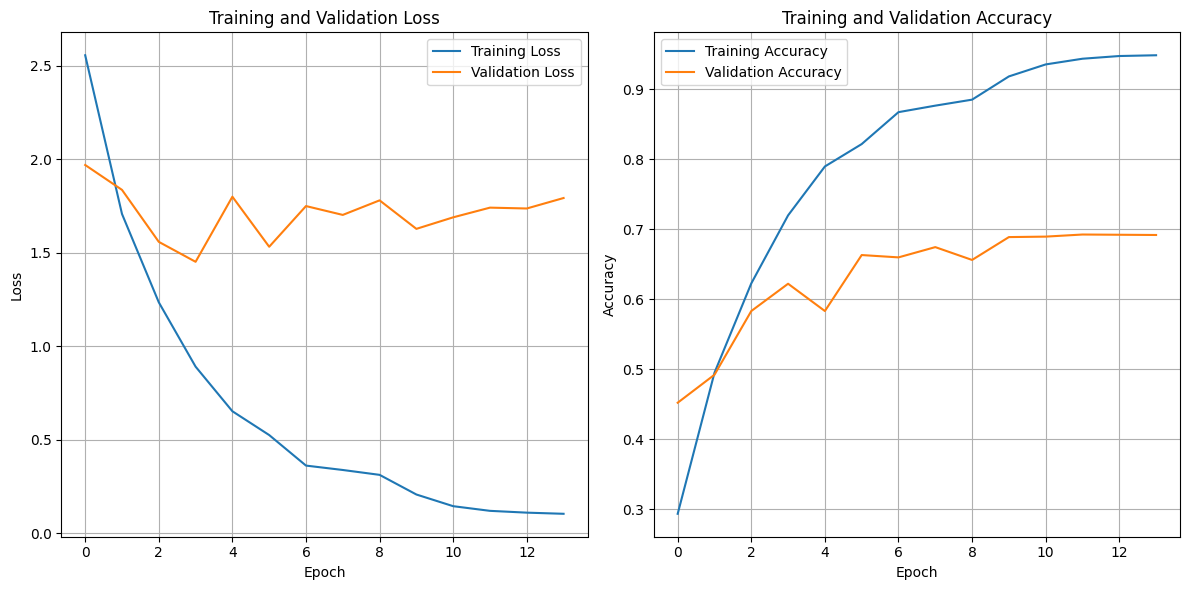

In [67]:
plt.figure(figsize=(12, 6))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


2/2 [==============================] - 0s 16ms/step
Accuracy: 62.20%


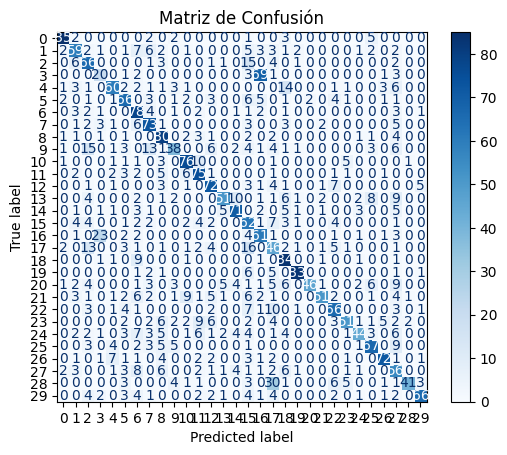

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score
import numpy as np

y_true = []
y_pred = []

for images, labels in classification_val_dataset:
    predictions = classifier.predict(images)  # Use the classifier model
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Convertir y_true y y_pred a arrays numpy
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calcular precisión
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2%}")

# Crear la matriz de confusión
num_classes = len(np.unique(y_true))  # Determinar dinámicamente el número de clases
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")

plt.show()